原始网络的最短路径和: 845.3342516486656
原始网络的边的总长度: 6.856625033424988


/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Population=100:   0%|          | 0/100 [00:00<?, ?it/s]

最佳个体网络图像已保存为 ./output4/cost266_best_network.png
Completed: Pop=100, Select=0.6666666666666666, Mutate=0.15 - Final Fitness=804.9983398024337


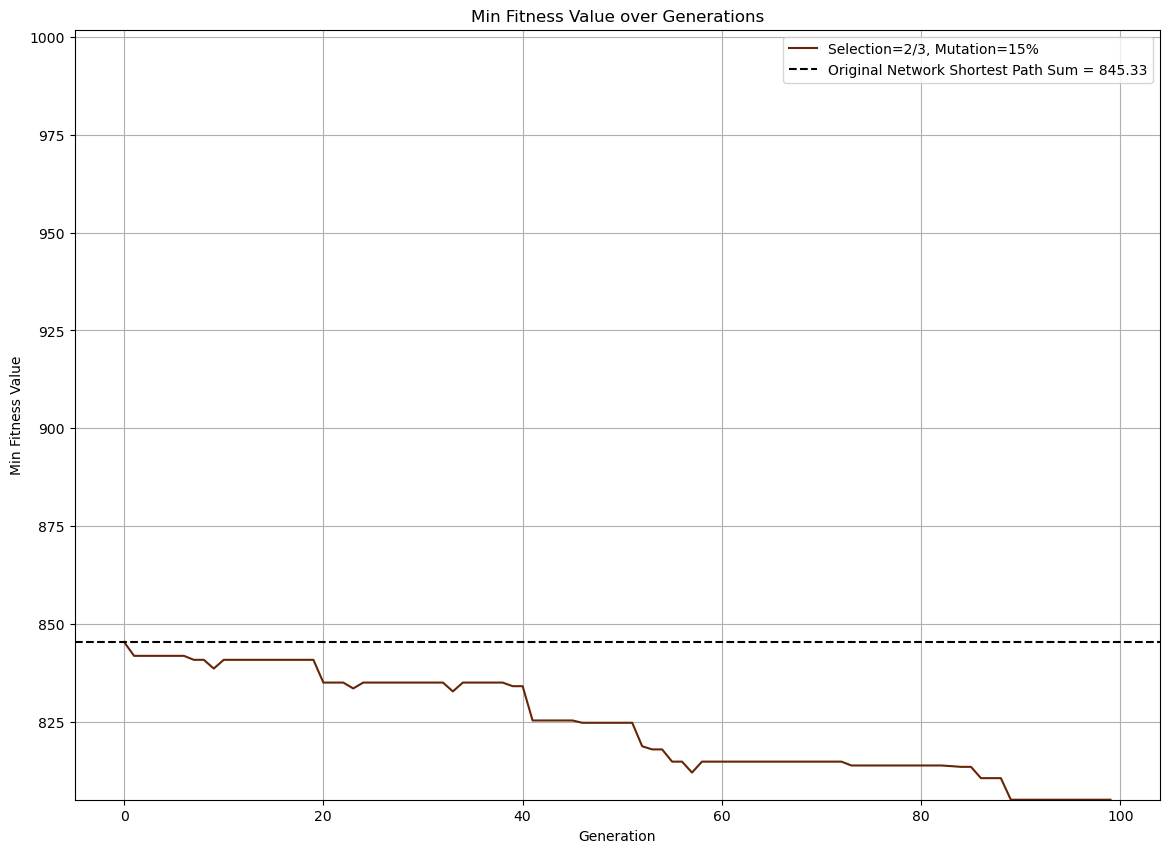

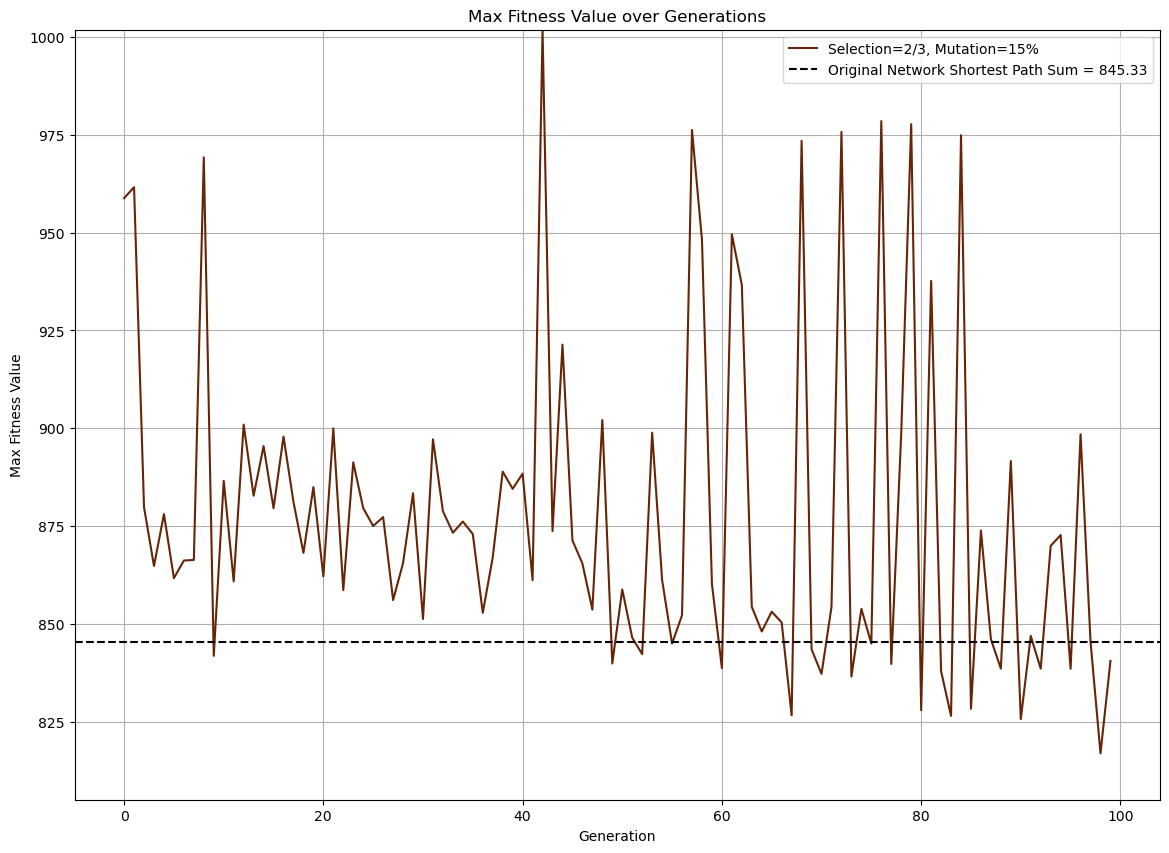

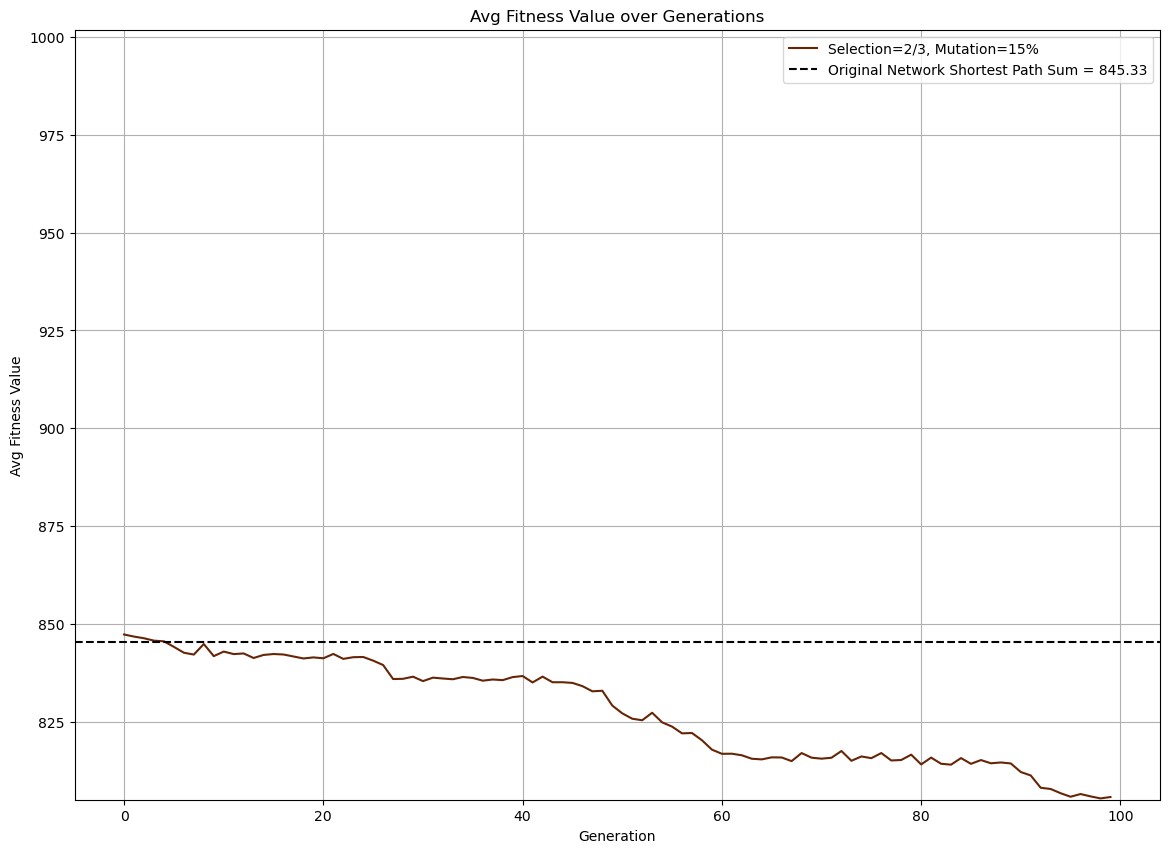

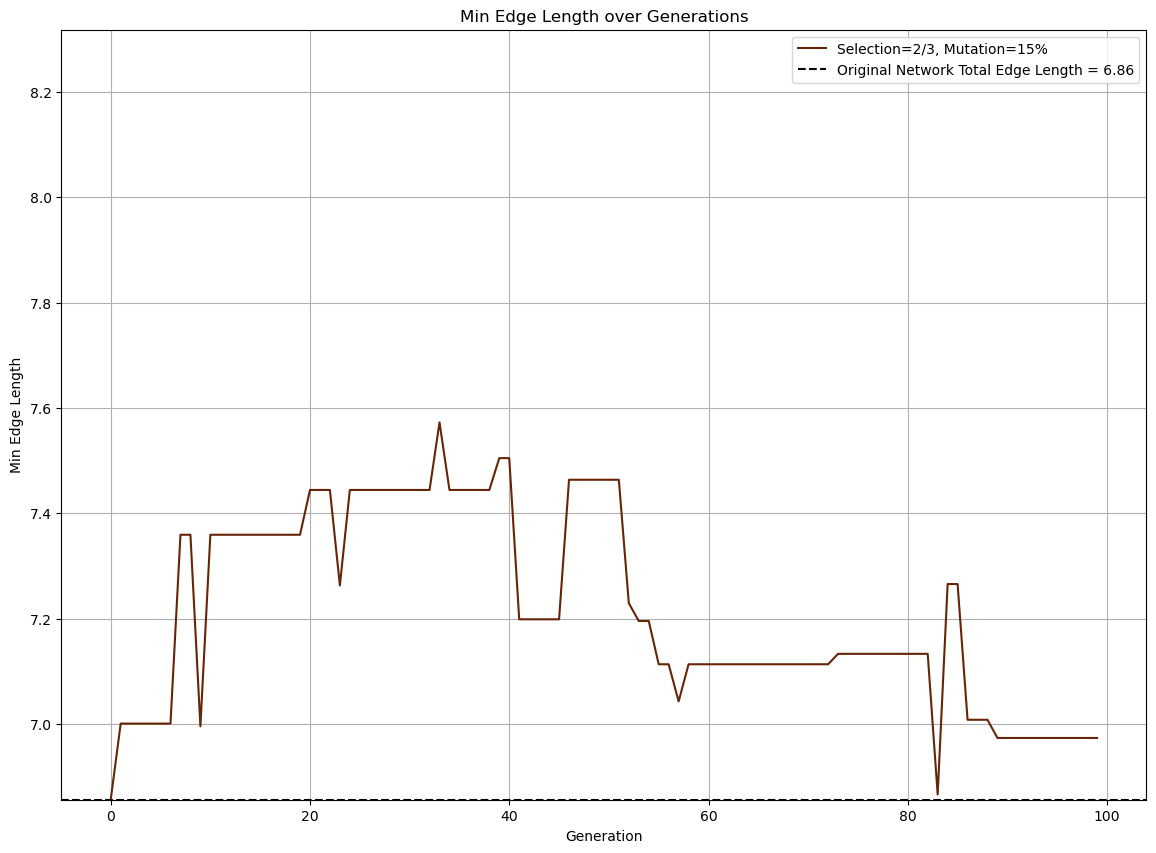

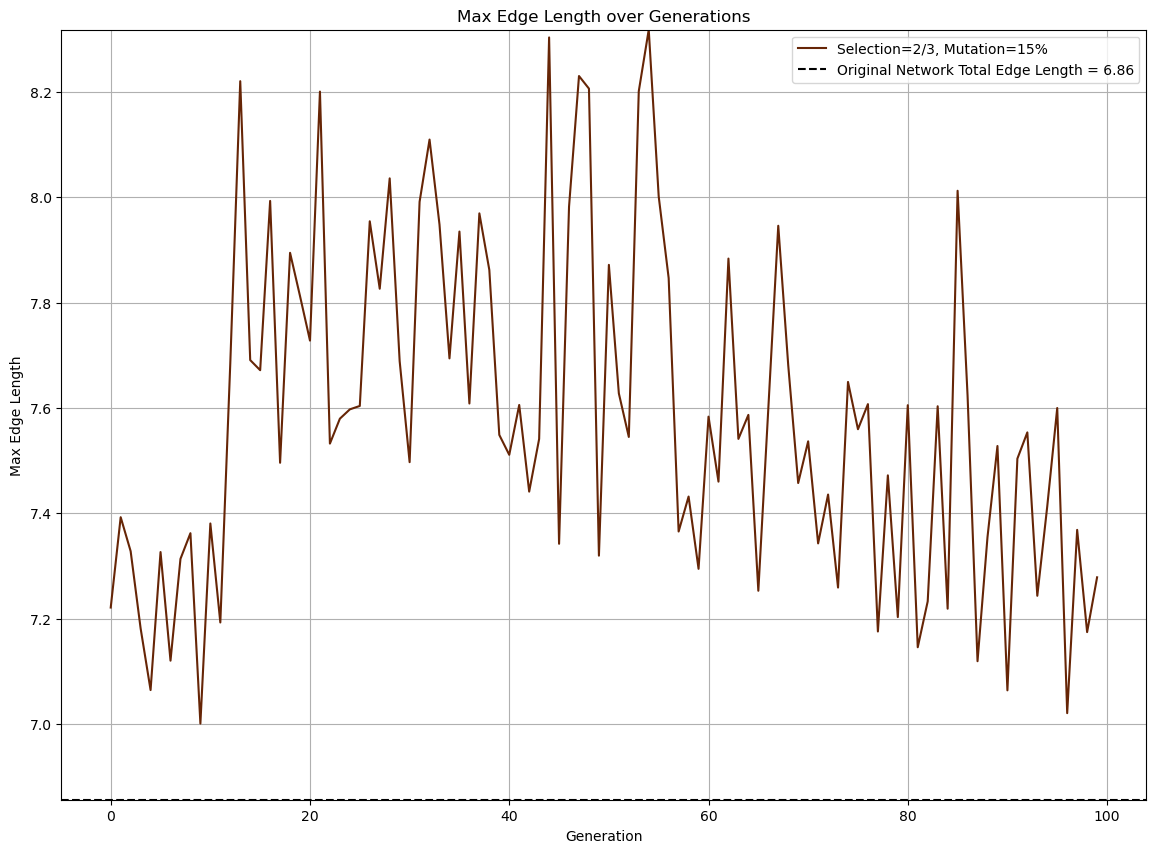

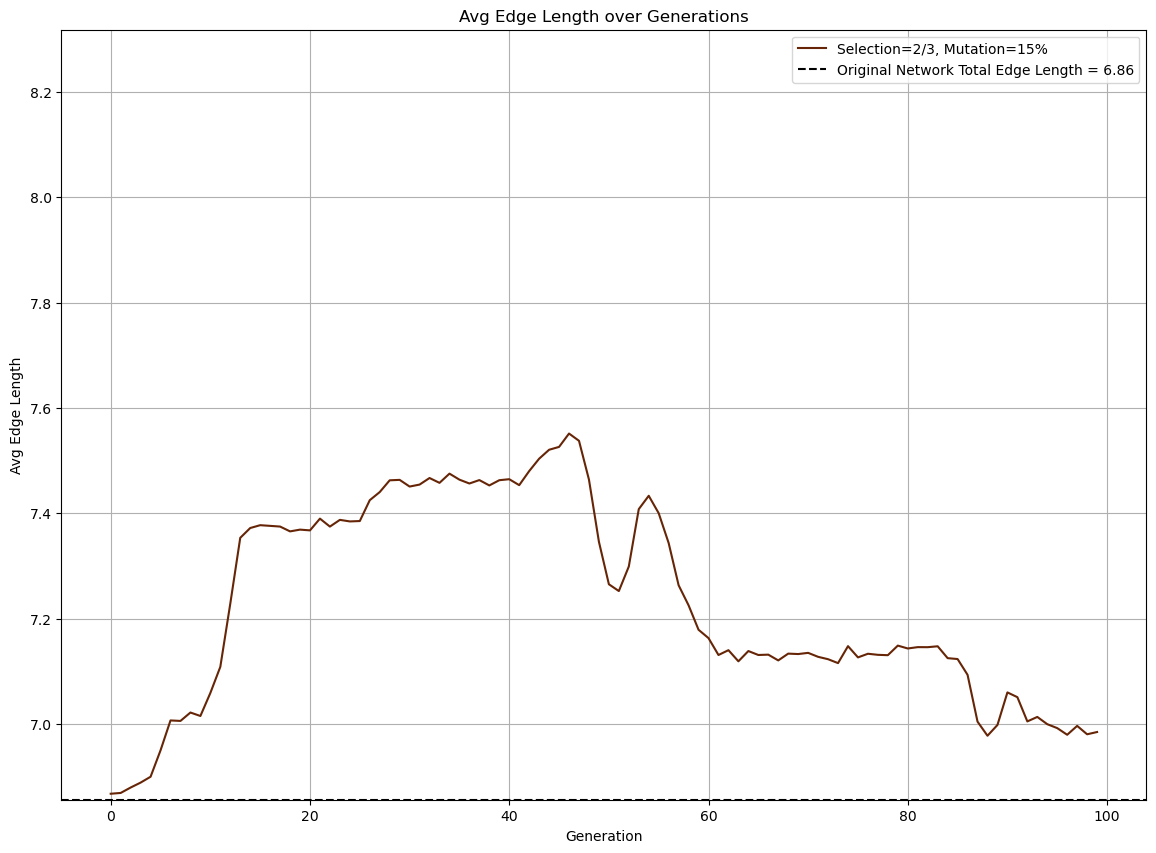

In [7]:
import numpy as np
from graph_tool.all import shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from fractions import Fraction
from tqdm.notebook import tqdm
import matplotlib.cm as cm  # 用于色系映射
import python_codes.newga_utils as ga  # 调整后的导入路径

# 读取图和位置信息
filename1 = "fukuoka_ascend_1024_rng"
read_graph, read_pos = fo.read_files(f"../networks_clusters/{filename1}.net")
num_edges = read_graph.num_edges()

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 计算原始网络的最短路径和
dist_matrix = shortest_distance(read_graph, weights=edge_weights).get_2d_array(range(read_graph.num_vertices()))
original_network_value = np.sum(dist_matrix[dist_matrix != np.inf])
print(f"原始网络的最短路径和: {original_network_value}")

# 计算原始网络的边的总长度
original_total_edge_length = np.sum([edge_weights[edge] for edge in read_graph.edges()])
print(f"原始网络的边的总长度: {original_total_edge_length}")

# 创建个体和适应度
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# 注册工具箱
toolbox = base.Toolbox()
toolbox.register("individual", ga.init_individual, read_graph=read_graph, edge_weights=edge_weights,
                 num_edges=num_edges)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", ga.evaluate, read_graph=read_graph, read_pos=read_pos, edge_weights=edge_weights)
toolbox.register("mate", ga.cxGraph, num_edges=num_edges)
toolbox.register("mutate", ga.mutGraph, num_edges=num_edges)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程，记录最小、最大和平均适应度值及边总长度
def main(population_size, selection_ratio, mutpb, initial_population, pbar, num_generations):
    num_selected = int(population_size * selection_ratio)
    num_offspring = population_size - num_selected
    cxpb = 0.5
    pop = initial_population[:]
    hof = tools.HallOfFame(1)  # 创建 Hall of Fame 用于保存最优个体
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    logbook = tools.Logbook()
    logbook.header = ["gen", "min", "max", "avg"]

    # 新增记录最小、最大适应度值个体的边总长度数组
    edge_length_min_values = []
    edge_length_max_values = []
    edge_length_avg_values = []

    for gen in range(num_generations):
        # 选择操作
        selected = toolbox.select(pop, num_selected)
        # 生成新的个体
        offspring = algorithms.varAnd(selected, toolbox, cxpb, mutpb)
        offspring = offspring[:num_offspring]
        # 更新种群
        pop[:] = selected + offspring
        # 评估适应度
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # 更新 Hall of Fame
        hof.update(pop)

        # 剔除适应度为无限大的个体
        valid_individuals = [ind for ind in pop if ind.fitness.values[0] != float('inf')]

        # 计算适应度值的最小、最大和平均值
        if valid_individuals:
            fitness_values = [ind.fitness.values[0] for ind in valid_individuals]
            min_fitness = np.min(fitness_values)
            max_fitness = np.max(fitness_values)
            avg_fitness = np.mean(fitness_values)

            # 找到最小和最大适应度对应的个体
            min_individual = valid_individuals[fitness_values.index(min_fitness)]
            max_individual = valid_individuals[fitness_values.index(max_fitness)]
        else:
            min_fitness = max_fitness = avg_fitness = float('inf')
            min_individual = max_individual = None

        # 记录和输出每一代的适应度统计值
        logbook.record(gen=gen, min=min_fitness, max=max_fitness, avg=avg_fitness)
        pbar.update(1)

        # 计算最小和最大适应度个体的边总长度
        if min_individual:
            min_graph, min_edge_weights = ga.individual_to_graph(min_individual, read_graph.num_vertices(), read_pos)
            min_total_edge_length = np.sum([min_edge_weights[edge] for edge in min_graph.edges()])
            edge_length_min_values.append(min_total_edge_length)
        else:
            edge_length_min_values.append(float('inf'))

        if max_individual:
            max_graph, max_edge_weights = ga.individual_to_graph(max_individual, read_graph.num_vertices(), read_pos)
            max_total_edge_length = np.sum([max_edge_weights[edge] for edge in max_graph.edges()])
            edge_length_max_values.append(max_total_edge_length)
        else:
            edge_length_max_values.append(float('inf'))

        # 计算平均边总长度
        if valid_individuals:
            edge_lengths = []
            for ind in valid_individuals:
                graph, edge_weights = ga.individual_to_graph(ind, read_graph.num_vertices(), read_pos)
                total_edge_length = np.sum([edge_weights[edge] for edge in graph.edges()])
                edge_lengths.append(total_edge_length)
            edge_length_avg_values.append(np.mean(edge_lengths))
        else:
            edge_length_avg_values.append(float('inf'))

    # 返回 logbook, edge_length_min_values, edge_length_max_values, edge_length_avg_values 以及最优个体（hof 中的最优）
    return logbook, edge_length_min_values, edge_length_max_values, edge_length_avg_values, hof


# 使用 Graph-tool 绘制最优网络的图像
def plot_best_network(individual, read_graph, read_pos, filename):
    # 将最优个体解码为图
    best_graph, best_edge_weights = ga.individual_to_graph(individual, read_graph.num_vertices(), read_pos)

    # 设置节点位置属性
    pos = best_graph.new_vertex_property("vector<double>")
    for v in best_graph.vertices():
        pos[v] = read_pos[int(v)]  # 赋值节点坐标

    # 绘制并保存图像
    output_path = f"./output4/{filename}_best_network.png"
    graph_draw(
        best_graph,
        pos=pos,
        edge_pen_width=2.0,  # 边的粗细
        edge_color="blue",  # 边的颜色
        vertex_fill_color="red",  # 节点颜色
        vertex_size=10,  # 节点大小
        output_size=(1000, 1000),
        output=output_path,
        bg_color=(1, 1, 1, 1)  # 背景白色
    )
    print(f"最佳个体网络图像已保存为 {output_path}")

# 参数配置
num_generations = 1000
population_sizes = [300]
selection_ratios = [2 / 3]
mutation_probs = [0.15]
progress_bars = {
    pop_size: tqdm(total=1 * num_generations, desc=f'Population={pop_size}', position=i, leave=True)
    for i, pop_size in enumerate(population_sizes)
}

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []
all_edge_lengths = []

# 执行主流程
initial_population = toolbox.population(n=population_sizes[0])
fitnesses = list(map(toolbox.evaluate, initial_population))
initial_fitness = min(fitnesses)[0]
all_logbooks = []
all_edge_lengths = []

# 执行每个种群大小的实验并绘图
for population_size in population_sizes:
    initial_population = toolbox.population(n=population_size)
    fitnesses = list(map(toolbox.evaluate, initial_population))
    initial_fitness = min(fitnesses)[0]

    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_params = {
            executor.submit(main, population_size, selection_ratio, mutpb, initial_population,
                            progress_bars[population_size], num_generations): (
                selection_ratio, mutpb)
            for selection_ratio in selection_ratios
            for mutpb in mutation_probs
        }

        for future in as_completed(future_to_params):
            selection_ratio, mutpb = future_to_params[future]
            try:
                # 这里修改为解包5个值
                logbook, edge_length_min_values, edge_length_max_values, edge_length_avg_values, hof = future.result()
                all_logbooks.append((logbook, selection_ratio, mutpb))
                all_edge_lengths.append(
                    (edge_length_min_values, edge_length_max_values, edge_length_avg_values, selection_ratio, mutpb)
                )

                # 提取最优个体并绘制网络
                if hof and len(hof) > 0:
                    best_individual = hof[0]
                    plot_best_network(best_individual, read_graph, read_pos, filename1)

                print(
                    f'Completed: Pop={population_size}, Select={selection_ratio}, Mutate={mutpb} - Final Fitness={logbook[-1]["min"]}')

            except Exception as ex:
                print(f'Error with Pop={population_size}, Select={selection_ratio}, Mutate={mutpb}: {ex}')
                # 打印详细的异常信息以便排查错误
                import traceback
                traceback.print_exc()


# 色系映射表
color_maps = {
    Fraction(1, 3): cm.Reds,
    Fraction(1, 2): cm.Blues,
    Fraction(2, 3): cm.YlOrBr,
    Fraction(3, 4): cm.Greens
}

# 对记录进行排序以确保顺序一致
all_logbooks.sort(key=lambda x: (x[1], x[2]))  # 按选择比例和变异概率排序
all_edge_lengths.sort(key=lambda x: (x[3], x[4]))

# 计算适应度和边总长度的全局最小和最大值
fitness_min = min(min(logbook.select("min")) for logbook, _, _ in all_logbooks)
fitness_max = max(max(logbook.select("max")) for logbook, _, _ in all_logbooks)
edge_length_min = min(min(edge_length_min_values) for edge_length_min_values, _, _, _, _ in all_edge_lengths)
edge_length_max = max(max(edge_length_max_values) for _, edge_length_max_values, _, _, _ in all_edge_lengths)

# 绘制适应度值的最小、最大和平均值图
for metric in ["min", "max", "avg"]:
    plt.figure(figsize=(14, 10))
    for logbook, selection_ratio, mutpb in all_logbooks:
        values = logbook.select(metric)
        generations = list(range(len(values)))
        color_map = color_maps[Fraction(selection_ratio).limit_denominator()]
        color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
        color = color_map(color_intensity)

        plt.plot(generations, values, linestyle="-", color=color,
                 label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

    plt.axhline(y=original_network_value, color='k', linestyle='--',
                label=f'Original Network Shortest Path Sum = {original_network_value:.2f}')
    plt.title(f"{metric.capitalize()} Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel(f"{metric.capitalize()} Fitness Value")
    plt.ylim(fitness_min, fitness_max)  # 设置统一的 y 轴范围
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./output4/{filename1}_{metric}_fitness_{num_generations}gens.png")
    plt.show()

# 绘制边总长度的最小、最大和平均值图
for metric, values in zip(["min", "max", "avg"], [0, 1, 2]):
    plt.figure(figsize=(14, 10))
    for edge_length_min_values, edge_length_max_values, edge_length_avg_values, selection_ratio, mutpb in all_edge_lengths:
        generations = list(range(num_generations))
        color_map = color_maps[Fraction(selection_ratio).limit_denominator()]
        color_intensity = (mutation_probs.index(mutpb) + 1) / len(mutation_probs)
        color = color_map(color_intensity)

        plt.plot(generations, [edge_length_min_values, edge_length_max_values, edge_length_avg_values][values],
                 linestyle="-", color=color,
                 label=f'Selection={Fraction(selection_ratio).limit_denominator()}, Mutation={int(mutpb * 100)}%')

    plt.axhline(y=original_total_edge_length, color='k', linestyle='--',
                label=f'Original Network Total Edge Length = {original_total_edge_length:.2f}')
    plt.title(f"{metric.capitalize()} Edge Length over Generations")
    plt.xlabel("Generation")
    plt.ylabel(f"{metric.capitalize()} Edge Length")
    plt.ylim(edge_length_min, edge_length_max)  # 设置统一的 y 轴范围
    plt.legend()
    plt.grid(True)
    plt.savefig(f"./output4/{filename1}_{metric}_edge_length_{num_generations}gens.png")
    plt.show()
